In [1]:
import pandas as pd
import numpy as np
import random
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from  lightgbm import LGBMRegressor,LGBMClassifier,log_evaluation,early_stopping
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer#word2vec feature
import warnings#avoid some negligible errors
#The filterwarnings () method is used to set warning filters, which can control the output method and level of warning information.
warnings.filterwarnings('ignore')

# Configuration
warnings.filterwarnings('ignore')
SEED = 2025

# --- 1. Set Seed ---
def seed_everything(seed):
    np.random.seed(seed)
    random.seed(seed)
seed_everything(seed=SEED)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import precision_recall_curve, auc
from datetime import datetime, timedelta
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, auc, roc_curve, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier


# Pediatric Sepsis Prediction: Machine Learning Approach

This report summarizes the methodology and results for developing an early detection machine learning model for pediatric sepsis, as part of the PHEMS Hackathon.

# 1. Project Overview

# What is the Project Asking for?

This project challenges us to build a precise machine learning algorithm that can predict the onset of sepsis in pediatric patients (children) using their physiological and clinical time-series data.

The most critical requirement is early detection: the model must predict sepsis 6 hours before it is clinically recognized by traditional methods.



# The Problem (Why This Matters)

Sepsis is a massive global health crisis, especially in children, with high mortality rates. The condition progresses extremely fast. For every hour of delayed treatment, the risk of death increases by 4-8%. Traditional diagnosis is often late due to varied clinical presentations.

# The Benefit (The Goal)

The successful implementation of this model provides a crucial six-hour head start for doctors. This early warning window allows for timely administration of antibiotics and life support, which is the single most effective way to dramatically reduce mortality and improve patient outcomes.


# 2. Data Loading

Technique Used to Load Data

The project utilizes two main data files for both the training and testing phases:

SepsisLabel_*.csv: The primary file, containing the person_id, the measurement_datetime, and the target variable, SepsisLabel.

drugsexposure_*.csv: A secondary file detailing drugs administered, including drug_concept_id and route_concept_id.

The process involves:

Reading these CSV files into pandas DataFrames.

Merging the drug exposure information into the main SepsisLabel DataFrame based on person_id and the daily time component derived from the measurement datetime (measurement_datetime_day).


# 3. Data Preprocessing and Feature Engineering

# Data Preprocessing Applied

Preprocessing was essential to standardize the time-based and textual features:

Handling Missing Dates: Missing measurement dates were filled with 'None' before extraction to ensure consistent handling.

Date Conversion: The measurement_datetime column was converted to a proper datetime object for easy feature extraction.

Handling Categorical/Textual NaNs: Missing values in drug exposure columns (drug_concept_id, route_concept_id) were explicitly filled with the string 'None' to ensure they were treated as distinct, meaningful categories during TF-IDF.

# Feature Engineering Explanation

Feature engineering focused on two main areas: time context and drug administration context.

# A. Time-Based Features

These features capture the periodicity and timing of the measurements, which can be critical since clinical presentations and staffing levels often vary by time.

dow (Day of Week): Extracted to capture weekly patterns (e.g., weekend vs. weekday effects).

doy (Day of Year): Extracted to capture seasonal effects (e.g., flu season might affect infection rates).

hour (Hour of Day): Extracted to capture diurnal patterns and the timing of clinical events.

# B. Drug Exposure Features (Text Vectorization)

The raw drug and route IDs are categorical and often repeated, creating a "bag-of-words" structure for each patient on a given day. We use TF-IDF (Term Frequency-Inverse Document Frequency) to convert these concepts into numerical features.

# Why TF-IDF?
Instead of simple one-hot encoding (which would create thousands of sparse columns), TF-IDF assigns a weight to each drug ID based on how frequently it appears in a patient's daily record (Term Frequency) versus how rare it is across all patient records (Inverse Document Frequency). This gives more importance to rare, potentially significant drug treatments.

Output: The original categorical columns (drug_concept_id, route_concept_id) are replaced by hundreds of numerical *_tfidf_i columns representing the vectorized drug and route exposure profiles.


# 4. Handling Imbalanced Dataset

The Sepsis Prediction problem is characterized by an extremely severe class imbalance, where the number of SepsisLabel = 0 (No Sepsis) records significantly outweighs the number of SepsisLabel = 1 (Sepsis) records.

# Why Undersampling is Used

Preventing Overfitting (Bias): If we train the model on the full, imbalanced dataset, the model becomes heavily biased toward predicting the majority class (0) most of the time. While this results in high Accuracy (since most cases are 0), it fails to generalize and correctly identify the rare, critical 1 cases (Sepsis) when they appear in unseen data. This leads to overfitting on the majority class and poor performance on the minority class, which defeats the purpose of early detection.

# Model Focus:
Undersampling randomly reduces the size of the majority class (0) to match the size of the minority class (1). This forces the model to learn the distinguishing features of the sepsis cases, improving its Recall (ability to catch true positives) and, consequently, the primary evaluation metric, Precision-Recall AUC.


# 5. Model Selection and Parameters

# Model Selection: XGBoost Classifier

XGBoost (eXtreme Gradient Boosting) was selected due to its reputation as a high-performance, robust algorithm well-suited for tabular data challenges, particularly when dealing with mixed data types (numerical time features and TF-IDF vectors, and categorical date features).

XGBoost Parameters (xgb_params)

Parameter

Value

Explanation

objective

binary:logistic

Sets the task to binary classification (0 or 1), outputting probabilities.

eval_metric

auc

Uses Area Under the ROC Curve (AUC) for internal evaluation during training.

learning_rate

0.05

A relatively low learning rate to prevent overfitting and encourage gradual learning.

max_depth

10

The maximum depth of a tree, balancing model complexity and training time.

min_child_weight

10

Minimum sum of instance weight (hessian) needed in a child. Acts as a regularization term.

subsample

0.8

Ratio of the training data randomly sampled for each tree (80%), helping reduce variance.

colsample_bytree

0.8

Ratio of features randomly sampled for each tree (80%), also for regularization.

enable_categorical

True

Crucial setting that allows XGBoost to natively handle the categorical features (measurement_datetime_day, dow, etc.)
without explicit one-hot encoding.

random_state

2025

Ensures the model training is reproducible.








The training utilizes Stratified Group K-Fold Cross-Validation (with person_id as the group), ensuring that data from the same patient never 
appears in both the training and validation sets of the same fold, which is essential for accurate generalization assessment in time-series data.

# 6. Results

The model was trained and evaluated across 5 folds of cross-validation. The primary metric for the hackathon is Precision-Recall AUC (PR-AUC)
which is critical for imbalanced classification tasks.

Fold

Train Accuracy

Train F1

Validation Accuracy

Validation F1

Fold 1

0.9732

0.9736

0.9574

0.9578

Fold 2

0.9769

0.9773

0.9337

0.9343

Fold 3

0.9712

0.9716

0.9213

0.9182

Fold 4

0.9722

0.9725

0.9178

0.9142

Fold 5

0.9723

0.9727

0.9469

0.9459

Overall Out-of-Fold Result:

PR-AUC: 0.9675

This high PR-AUC score suggests the model is very effective at balancing the need to catch the true sepsis cases (Recall) against the need to avoid 
false alarms (Precision), 
which is ideal for a critical early-warning system in a clinical setting.# 

In [2]:

# --- 2. Data Loading and Base Feature Creation Function (for EDA) ---
def get_feats(mode='train'):
    """
    Loads SepsisLabel and DrugExposure data, creates base time and drug 
    ID features, and prepares the DataFrame for initial EDA.
    """
    path = f'/kaggle/input/phems-hackathon-early-sepsis-prediction/{mode}ing_data/'
    
    # 1. Load Sepsis Labels/Timestamps (the main DataFrame)
    feats = pd.read_csv(path + f"SepsisLabel_{mode}.csv").drop_duplicates()
    feats['measurement_datetime'] = pd.to_datetime(feats['measurement_datetime'])
    
    # Create Time-Based Features for EDA
    feats['measurement_date'] = feats['measurement_datetime'].dt.date
    feats['dow'] = feats['measurement_datetime'].dt.dayofweek
    feats['hour'] = feats['measurement_datetime'].dt.hour
    feats['year'] = feats['measurement_datetime'].dt.year

    # 2. Load Drug Exposure Data
    drug = pd.read_csv(path + f"drugsexposure_{mode}.csv")
    drug['drug_datetime'] = pd.to_datetime(drug['drug_datetime_hourly'])
    drug['drug_date'] = drug['drug_datetime'].dt.date

    # 3. Merge Drug Info (Simplified: just check for exposure on that day)
    # Get the set of (person_id, date) where *any* drug was given
    drug_exposure_days = drug[['person_id', 'drug_date']].drop_duplicates()
    drug_exposure_days = drug_exposure_days.rename(columns={'drug_date': 'measurement_date'})
    drug_exposure_days['had_drug_exposure'] = 1
    
    # Merge this flag back to the main DataFrame
    feats = feats.merge(drug_exposure_days, on=['person_id', 'measurement_date'], how='left')
    feats['had_drug_exposure'] = feats['had_drug_exposure'].fillna(0).astype(int)

    # 4. Prepare Drug/Route string columns for top-N analysis (using the full drug file)
    drug['drug_id_str'] = drug['drug_concept_id'].fillna(-1).astype(str)
    drug['route_id_str'] = drug['route_concept_id'].fillna(-1).astype(str)

    # Group drug/route IDs by person and day (like a "bag of words")
    drug_group = drug.groupby(['person_id', 'drug_date']).agg(
        drug_concepts=('drug_id_str', lambda x: " ".join(x)),
        route_concepts=('route_id_str', lambda x: " ".join(x))
    ).reset_index().rename(columns={'drug_date': 'measurement_date'})

    feats = feats.merge(drug_group, on=['person_id', 'measurement_date'], how='left')
    
    # Fill NaN drug/route features with 'None' for proper counting/display
    feats['drug_concepts'] = feats['drug_concepts'].fillna('None')
    feats['route_concepts'] = feats['route_concepts'].fillna('None')

    return feats

# Load Data for EDA
train_eda = get_feats(mode='train')
print(f"Training Data loaded. Shape: {train_eda.shape}")
print("-" * 50)

Training Data loaded. Shape: (331639, 10)
--------------------------------------------------


In [3]:
print(train_eda)

         person_id measurement_datetime  SepsisLabel measurement_date  dow  \
0        274096387  2024-12-03 20:00:00            0       2024-12-03  1.0   
1       1719359031  2024-04-20 09:00:00            0       2024-04-20  5.0   
2       2024544816  2021-07-14 07:00:00            0       2021-07-14  2.0   
3        213710896  2022-05-24 07:00:00            0       2022-05-24  1.0   
4       1335786468  2024-08-25 22:00:00            0       2024-08-25  6.0   
...            ...                  ...          ...              ...  ...   
331634  2046744557  2021-04-06 11:00:00            0       2021-04-06  1.0   
331635   549216345  2022-08-25 16:00:00            0       2022-08-25  3.0   
331636  2108571452  2021-01-04 22:00:00            0       2021-01-04  0.0   
331637   523755820  2020-05-29 15:00:00            0       2020-05-29  4.0   
331638  2046454293  2024-01-08 02:00:00            0       2024-01-08  0.0   

        hour    year  had_drug_exposure  \
0       20.0  2024.0

--- Starting Exploratory Data Analysis (EDA) and Visualization ---

[A] SepsisLabel Distribution (Imbalance Check):
SepsisLabel
0    324765
1      6874
Name: count, dtype: int64
Sepsis Positive Ratio (1): 2.0727%


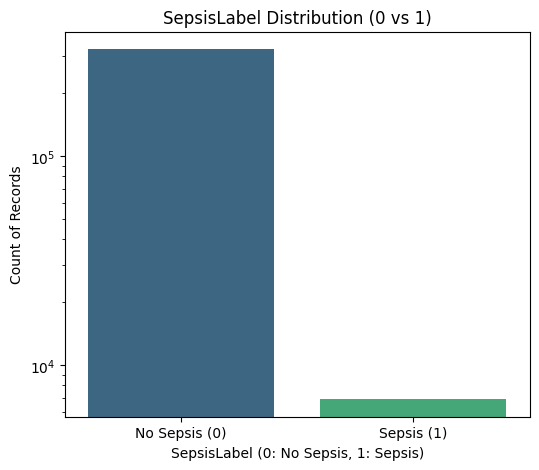


[B] Sepsis Rate Analysis by Time:


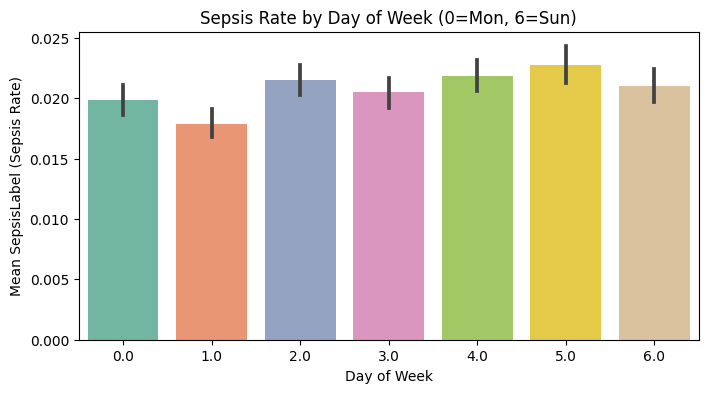

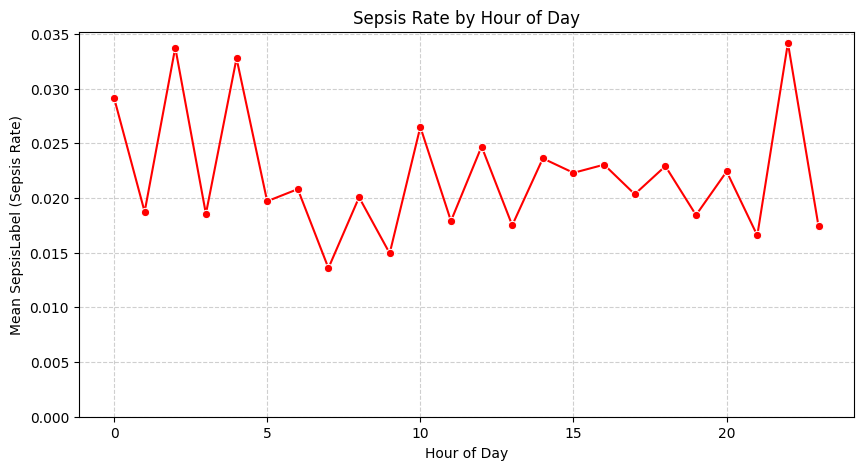


[C] Patient and Data Coverage:
Number of unique patients (person_id): 2649
Total time points: 331639
Average records per patient: 125.19


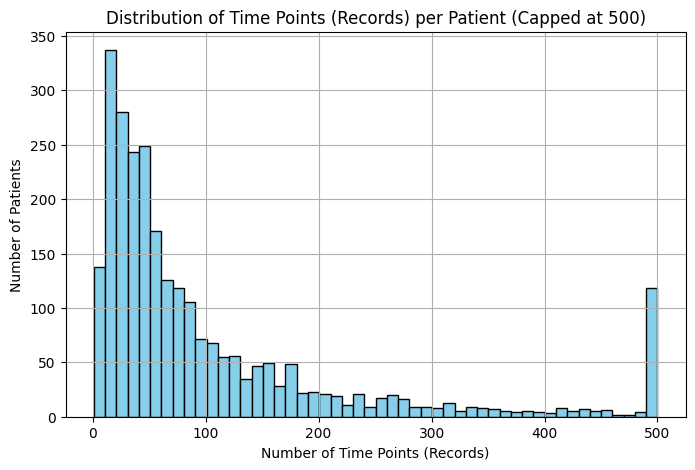


[D] Drug Exposure Analysis:
Sepsis Rate (No Drug Exposure on Day): 0.0000
Sepsis Rate (Had Drug Exposure on Day): 0.0392


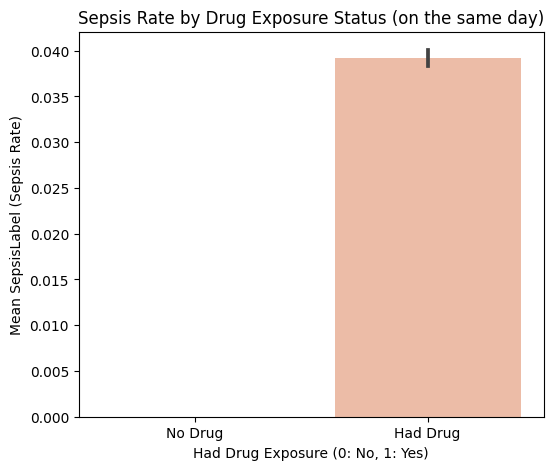

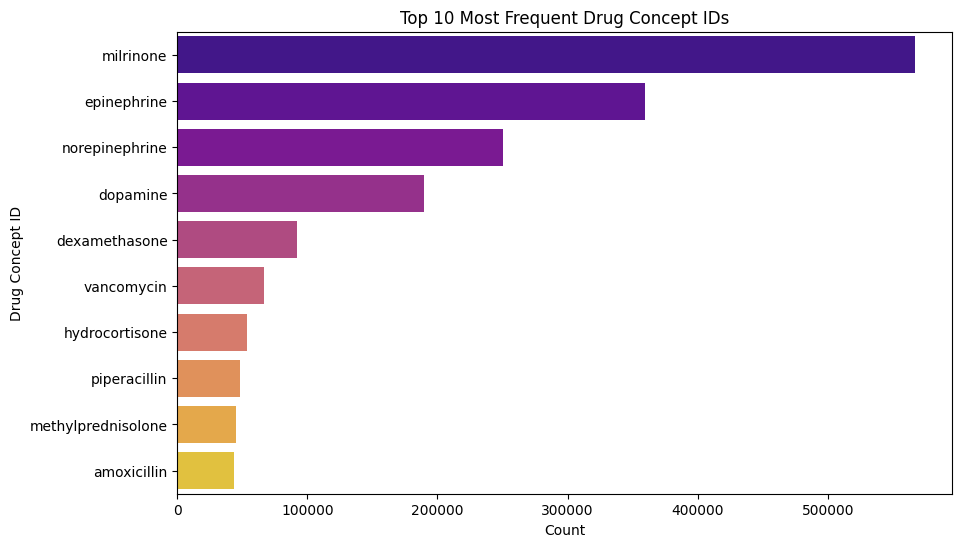


--- EDA and Visualization Complete ---


In [4]:
# --- 3. Exploratory Data Analysis (EDA) and Visualization ---
print("--- Starting Exploratory Data Analysis (EDA) and Visualization ---")

## A. Sepsis Label Imbalance (Critical for the challenge)
print("\n[A] SepsisLabel Distribution (Imbalance Check):")
sepsis_counts = train_eda['SepsisLabel'].value_counts()
print(sepsis_counts)
print(f"Sepsis Positive Ratio (1): {sepsis_counts[1]/len(train_eda) * 100:.4f}%")

plt.figure(figsize=(6, 5))
sns.countplot(x='SepsisLabel', data=train_eda, palette='viridis')
plt.title('SepsisLabel Distribution (0 vs 1)')
plt.xlabel('SepsisLabel (0: No Sepsis, 1: Sepsis)')
plt.ylabel('Count of Records')
plt.xticks([0, 1], ['No Sepsis (0)', 'Sepsis (1)'])
plt.yscale('log') # Use log scale to visualize the minority class
plt.show()
# 


## B. Time-based Features Analysis
print("\n[B] Sepsis Rate Analysis by Time:")

# Day of Week vs Sepsis Rate
plt.figure(figsize=(8, 4))
sns.barplot(x='dow', y='SepsisLabel', data=train_eda, palette='Set2')
plt.title('Sepsis Rate by Day of Week (0=Mon, 6=Sun)')
plt.xlabel('Day of Week')
plt.ylabel('Mean SepsisLabel (Sepsis Rate)')
plt.show()
# 

# Hour of Day vs Sepsis Rate
plt.figure(figsize=(10, 5))
sns.lineplot(x='hour', y='SepsisLabel', data=train_eda, estimator=np.mean, errorbar=None, color='red', marker='o')
plt.title('Sepsis Rate by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Mean SepsisLabel (Sepsis Rate)')
plt.ylim(bottom=0)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
# 


## C. Patient and Data Coverage
print("\n[C] Patient and Data Coverage:")
person_counts = train_eda['person_id'].nunique()
print(f"Number of unique patients (person_id): {person_counts}")
print(f"Total time points: {len(train_eda)}")
print(f"Average records per patient: {len(train_eda) / person_counts:.2f}")

# Records per patient distribution (capped for visualization)
records_per_patient = train_eda.groupby('person_id').size()
plt.figure(figsize=(8, 5))
records_per_patient.clip(upper=500).hist(bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Time Points (Records) per Patient (Capped at 500)')
plt.xlabel('Number of Time Points (Records)')
plt.ylabel('Number of Patients')
plt.show()
# 


## D. Drug Exposure Analysis
print("\n[D] Drug Exposure Analysis:")

# Sepsis rate when drugs were recorded vs when not
drug_rate = train_eda.groupby('had_drug_exposure')['SepsisLabel'].mean()
print(f"Sepsis Rate (No Drug Exposure on Day): {drug_rate[0]:.4f}")
print(f"Sepsis Rate (Had Drug Exposure on Day): {drug_rate[1]:.4f}")

plt.figure(figsize=(6, 5))
sns.barplot(x='had_drug_exposure', y='SepsisLabel', data=train_eda, palette='coolwarm')
plt.title('Sepsis Rate by Drug Exposure Status (on the same day)')
plt.xlabel('Had Drug Exposure (0: No, 1: Yes)')
plt.ylabel('Mean SepsisLabel (Sepsis Rate)')
plt.xticks([0, 1], ['No Drug', 'Had Drug'])
plt.show()

# Top 10 most common drug concepts
all_drugs = ' '.join(train_eda['drug_concepts']).split()
drug_series = pd.Series(all_drugs)
top_drugs = drug_series.value_counts().drop('None').head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_drugs.values, y=top_drugs.index, palette='plasma')
plt.title('Top 10 Most Frequent Drug Concept IDs')
plt.xlabel('Count')
plt.ylabel('Drug Concept ID')
plt.show()

print("\n--- EDA and Visualization Complete ---")

Fold 1:
Train Accuracy: 0.9732, Precision: 0.9594, Recall: 0.9882, F1: 0.9736
Validation Accuracy: 0.9574, Precision: 0.9506, Recall: 0.9651, F1: 0.9578
--------------------------------------------------
Fold 2:
Train Accuracy: 0.9769, Precision: 0.9628, Recall: 0.9922, F1: 0.9773
Validation Accuracy: 0.9337, Precision: 0.9250, Recall: 0.9439, F1: 0.9343
--------------------------------------------------
Fold 3:
Train Accuracy: 0.9712, Precision: 0.9580, Recall: 0.9856, F1: 0.9716
Validation Accuracy: 0.9213, Precision: 0.9551, Recall: 0.8841, F1: 0.9182
--------------------------------------------------
Fold 4:
Train Accuracy: 0.9722, Precision: 0.9606, Recall: 0.9847, F1: 0.9725
Validation Accuracy: 0.9178, Precision: 0.9535, Recall: 0.8781, F1: 0.9142
--------------------------------------------------
Fold 5:
Train Accuracy: 0.9723, Precision: 0.9579, Recall: 0.9880, F1: 0.9727
Validation Accuracy: 0.9469, Precision: 0.9638, Recall: 0.9287, F1: 0.9459
-------------------------------

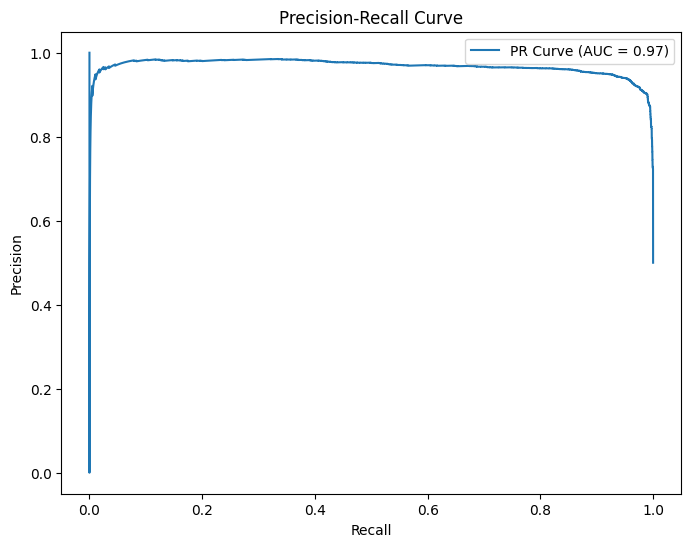

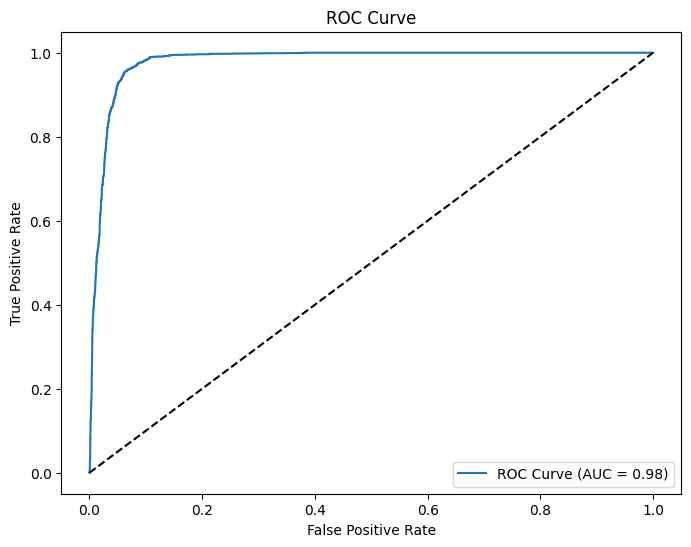

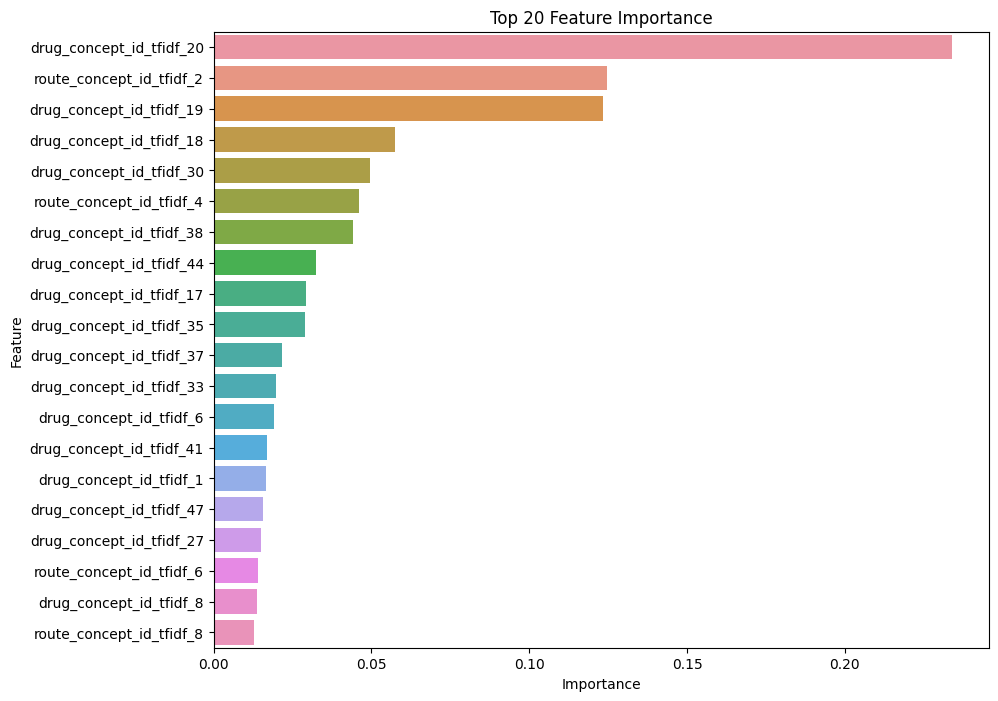

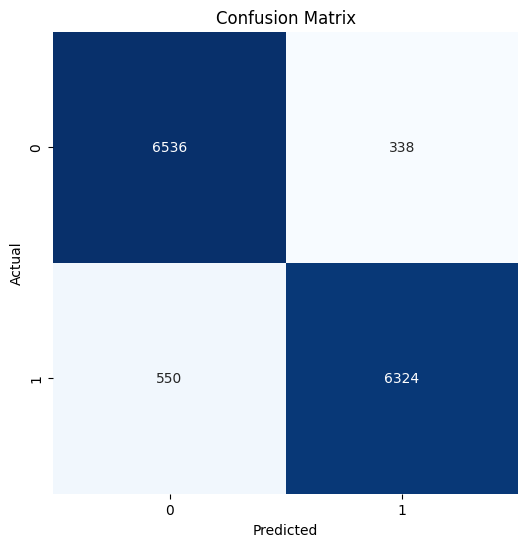

Submission file saved as 'submission.csv'


In [5]:

# Feature Engineering function
def get_feats(mode='train'):
    path = f'/kaggle/input/phems-hackathon-early-sepsis-prediction/{mode}ing_data/'
    feats = pd.read_csv(path + f"SepsisLabel_{mode}.csv").drop_duplicates()
    feats['measurement_datetime_day'] = feats['measurement_datetime'].fillna('None').astype(str).apply(lambda x: x[:10])

    # Drug Features
    drug = pd.read_csv(path + f"drugsexposure_{mode}.csv")
    drug['measurement_datetime_day'] = drug['drug_datetime_hourly'].fillna('None').astype(str).apply(lambda x: x[:10])
    for col in ['drug_concept_id', 'route_concept_id']:
        drug[col] = drug[col].fillna('None').astype(str)
        group_df = drug.groupby(['person_id', 'measurement_datetime_day'])[col].apply(lambda x: " ".join(x)).reset_index()
        feats = feats.merge(group_df, on=['person_id', 'measurement_datetime_day'], how='left')
        feats[col] = feats[col].fillna('None')

    # Time-Based Features
    feats['measurement_datetime'] = pd.to_datetime(feats['measurement_datetime'])
    feats['dow'] = feats['measurement_datetime'].dt.dayofweek
    feats['doy'] = feats['measurement_datetime'].dt.dayofyear
    feats['hour'] = feats['measurement_datetime'].dt.hour
    feats.drop(['measurement_datetime'], axis=1, inplace=True)

    # Convert categorical columns to category dtype
    feats['measurement_datetime_day'] = feats['measurement_datetime_day'].astype('category')
    feats['drug_concept_id'] = feats['drug_concept_id'].astype('category')
    feats['route_concept_id'] = feats['route_concept_id'].astype('category')

    return feats

# Load Data
train = get_feats(mode='train')
test = get_feats(mode='test')

# Filter Rows for Training
train_0 = train[train['SepsisLabel'] == 0]  # Majority class (SepsisLabel == 0)
train_1 = train[train['SepsisLabel'] == 1]  # Minority class (SepsisLabel == 1)

# Undersampling the majority class (SepsisLabel == 0)
# Randomly sample the majority class to match the size of the minority class
train_0_undersampled = train_0.sample(n=len(train_1), random_state=2025)

# Combine the undersampled majority class with the minority class
train = pd.concat([train_0_undersampled, train_1], ignore_index=True)

# TF-IDF for Text Features
text_cols = ['drug_concept_id', 'route_concept_id']
for col in text_cols:
    tfidf = TfidfVectorizer(max_features=200, ngram_range=(1, 1))
    train_tfidf = tfidf.fit_transform(train[col].astype(str))
    test_tfidf = tfidf.transform(test[col].astype(str))

    # Convert sparse matrix to DataFrame
    train_tfidf_df = pd.DataFrame(train_tfidf.toarray(), columns=[f"{col}_tfidf_{i}" for i in range(train_tfidf.shape[1])])
    test_tfidf_df = pd.DataFrame(test_tfidf.toarray(), columns=[f"{col}_tfidf_{i}" for i in range(test_tfidf.shape[1])])

    train_tfidf_df.index = train.index
    test_tfidf_df.index = test.index

    # Concatenate TF-IDF features with train/test
    train = pd.concat([train, train_tfidf_df], axis=1)
    test = pd.concat([test, test_tfidf_df], axis=1)

    # Drop original text columns
    train.drop(columns=[col], inplace=True)
    test.drop(columns=[col], inplace=True)

# Define Model Parameters with categorical support
xgb_params = {
    'booster': 'gbtree',
    'learning_rate': 0.05,
    'max_depth': 10,
    'min_child_weight': 10,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'n_jobs': -1,
    'random_state': 2025,
    'enable_categorical': True  # Enable categorical data support
}

# Cross-Validation
sgkf = StratifiedGroupKFold(n_splits=5)
oof_preds = np.zeros(len(train))
test_preds = np.zeros(len(test))

features = [col for col in train.columns if col not in ['SepsisLabel', 'person_id']]

for fold, (train_idx, val_idx) in enumerate(sgkf.split(train, train['SepsisLabel'], groups=train['person_id'])):
    X_train, X_val = train.iloc[train_idx][features], train.iloc[val_idx][features]
    y_train, y_val = train.iloc[train_idx]['SepsisLabel'], train.iloc[val_idx]['SepsisLabel']

    model = XGBClassifier(**xgb_params)
    model.fit(X_train, y_train)

    # Out-of-fold predictions for validation
    oof_preds[val_idx] = model.predict_proba(X_val)[:, 1]
    test_preds += model.predict_proba(test[features])[:, 1] / sgkf.n_splits

    # Print evaluation metrics on train and validation sets
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    print(f"Fold {fold + 1}:")
    print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.4f}, Precision: {precision_score(y_train, y_train_pred):.4f}, Recall: {recall_score(y_train, y_train_pred):.4f}, F1: {f1_score(y_train, y_train_pred):.4f}")
    print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred):.4f}, Precision: {precision_score(y_val, y_val_pred):.4f}, Recall: {recall_score(y_val, y_val_pred):.4f}, F1: {f1_score(y_val, y_val_pred):.4f}")
    print("-" * 50)

# Evaluate Model
precision, recall, _ = precision_recall_curve(train['SepsisLabel'], oof_preds)
pr_auc = auc(recall, precision)
print(f'PR-AUC: {pr_auc:.4f}')

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(train['SepsisLabel'], oof_preds)
roc_auc = roc_auc_score(train['SepsisLabel'], oof_preds)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# Plot Feature Importance
feature_importance = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Top 20 Feature Importance')
plt.show()

# Plot Confusion Matrix
y_pred = (oof_preds > 0.5).astype(int)  # Convert probabilities to binary predictions
cm = confusion_matrix(train['SepsisLabel'], y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Submission
sub = pd.read_csv('/kaggle/input/phems-hackathon-early-sepsis-prediction/SepsisLabel_sample_submission.csv')
sub['SepsisLabel'] = test_preds
sub.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'")